In [1073]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.6f}'.format

# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


In [1074]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


## 1.스케일링(standard_scale)

In [1075]:
# 데이터 불러오기
df = pd.read_csv('./datasets/원본data.csv')
df['Date'] = pd.to_datetime(df['Date'])  # 'Date' 열을 datetime 객체로 변환
df.set_index('Date', inplace=True)

df=df.drop(['원위안', '유가', '은', '외환보유액','구리'],axis=1) # G7 이미 삭제된 데이터셋
dataset =df.values
# dataset=df[['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']].values
scaler=StandardScaler()
dataset= scaler.fit_transform(dataset)
print(dataset)

[[ 0.93589755  1.43327182 -0.74157178 ...  2.07114449 -1.74913464
  -1.49457805]
 [ 0.80523213  1.42294476 -0.75485022 ...  2.01342627 -1.57284691
  -1.75012721]
 [ 0.7220814   1.26803893 -0.75485022 ...  2.85611229 -1.33988349
  -1.81061445]
 ...
 [-1.58238152 -0.73540982  0.37381684 ... -0.75285063  1.76937084
  -0.3938106 ]
 [-1.61801754 -0.73540982 -0.40961088 ... -0.59701144  1.4817088
  -0.27075728]
 [-1.66553224 -0.61148516 -0.3432187  ... -0.94751845  1.95422583
  -0.27316174]]


In [1076]:
# from google.colab import drive
# drive.mount('/content/drive')

- scaled_df : 5개의 feature 삭제하고 남은 전체 데이터프레임
- feature_df : scaled_df중 종가를 제외한 부분
- label_df : scaled_df의 종가 부분

In [1077]:
scaled_df = pd.DataFrame(dataset, columns=df.columns,index=df.index)
feature_df = scaled_df[['재고순환지표', '경제심리지수', '기계류내수출', '건설수주액', '수출입물가비율', '코스피', '장단기', '뉴스심리지수', '원달러', '원엔', 'CD', 'G20', '미장단기', '거래량', '천연가스', '금','종가']]
label_df = scaled_df['종가']

#### 사용한 데이터 :  내생 변수 -> 9개

In [1078]:
feature_df_2 = feature_df[['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']]

## 2.tesnorflow에 사용될 데이터로 전처리

### 데이터프레임을 --> array형태로
    

In [1079]:
feature_np = feature_df_2.to_numpy()
label_np = label_df.to_numpy()

In [1080]:
feature_np.shape

(184, 9)

### tensorflow에서 사용하기 위한 데이터 형태 만들기
    - feature : 학습시킬 데이터
    - label : 예측할 데이터
    - window_size : 몇개 전 데이터로 다음값을 예측할 것인지
    - return: (row 총 개수 - windows , window_size , feature 개수) , (row 총 개수 - windows, )


#### 1. window로 3차원 텐서로 만들기

In [1081]:
def make_sequence_dataset(feature, label, window_size):
  feature_list = []
  label_list = []

  for i in range(len(feature)-window_size):
    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])

  return np.array(feature_list), np.array(label_list) # 3차원 텐서

In [1082]:
window_size=1
X, Y = make_sequence_dataset(feature_np, label_np, window_size) # batchsize, time steps ,input dims
print(X.shape,Y.shape)
print(X)


(183, 1, 9) (183,)
[[[ 0.93589755  1.43327182  1.72403372 ...  2.89919104  1.24146097
   -1.49457805]]

 [[ 0.80523213  1.42294476  1.50708726 ...  2.58109256  1.06202031
   -1.75012721]]

 [[ 0.7220814   1.26803893  1.27464463 ...  2.33833319  0.85593723
   -1.81061445]]

 ...

 [[-1.48735212 -0.75606393 -1.37520134 ...  1.34218269 -0.46492013
   -0.63320479]]

 [[-1.58238152 -0.73540982 -1.45268221 ...  1.0157132  -0.42983655
   -0.3938106 ]]

 [[-1.61801754 -0.73540982 -1.48367456 ...  1.03245522 -0.39249759
   -0.27075728]]]


In [1083]:
print(Y)

[-1.75012721 -1.81061445 -1.58028708 -1.35246436 -1.41515568 -1.66449332
 -1.70887567 -1.83648745 -1.79380826 -2.30069879 -2.55885279 -2.42462874
 -2.41641349 -2.55211529 -2.22317995 -1.91175211 -1.79774056 -1.79481012
 -1.47837298 -1.18578008 -1.17478468 -1.2364491  -1.26249743 -0.92369379
 -1.10933824 -1.06886314 -0.93649253 -0.75853734 -0.71275239 -0.58772039
 -0.30582234 -0.32926584  0.12878406  0.56877546  0.59835534  0.70365072
  0.52714822  0.46022404  1.12202701  1.8621002   1.79738011  1.93293162
  1.99975561  1.27924372  1.10559652  1.43801331  1.26717132  1.01074553
  1.13562724  1.22008395  1.38952334  1.66508464  1.18957734  1.14466902
  1.18188808  1.32427728  1.31854163  0.75201546  0.98509794  0.91732218
  0.78177067  1.06081343  1.04976793  0.67362     0.97285021  0.9100587
  1.02407025  1.14404286  1.34203523  1.37239155  1.38288602  0.99281225
  1.13049271  1.29652578  1.4196292   1.1202988   1.19606438  1.16716075
  1.49862578  1.4142943   0.92075355  0.49268427  0.

#### 2. train,test으로 데이터 분할
    - split : 테스트 개수

In [1084]:
split = -36
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)


(147, 1, 9) (147,) (36, 1, 9) (36,)


## 3. LSTM 모델링

In [1085]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import get_custom_objects

def tanh(x):
    alpha = tf.constant(0.1)  # P-ReLU 매개변수
    return tf.keras.activations.relu(x) - alpha * tf.keras.activations.relu(-x)

get_custom_objects().update({'prelu_activation': prelu_activation})


def e_relu_activation(x):
    alpha = tf.constant(1.0)  # e-ReLU 매개변수
    return tf.keras.activations.relu(x) - alpha * (tf.exp(x) - 1)

get_custom_objects().update({'e_relu_activation': e_relu_activation})


# LSTM 모델 생성
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True,dropout=0.1,recurrent_activation='e_relu_activation',activation='e_relu_activation'), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.1,activation='tanh')))
model.add(Bidirectional(LSTM(256, return_sequences=False, dropout=0.1,recurrent_activation='e_relu_activation',activation='e_relu_activation')))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_153 (Bidirect  (None, 1, 512)           544768    
 ional)                                                          
                                                                 
 bidirectional_154 (Bidirect  (None, 1, 512)           1574912   
 ional)                                                          
                                                                 
 bidirectional_155 (Bidirect  (None, 512)              1574912   
 ional)                                                          
                                                                 
 dense_47 (Dense)            (None, 1)                 513       
                                                                 
Total params: 3,695,105
Trainable params: 3,695,105
Non-trainable params: 0
___________________________________________

In [1086]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=8, verbose=1)


Epoch 1/100


ResourceExhaustedError: in user code:

    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1054, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer.py", line 543, in minimize
        self.apply_gradients(grads_and_vars)
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer.py", line 1174, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer.py", line 637, in apply_gradients
        self.build(trainable_variables)
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\adam.py", line 139, in build
        self.add_variable_from_reference(
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer.py", line 1106, in add_variable_from_reference
        return super().add_variable_from_reference(
    File "c:\Users\dgh06\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer.py", line 507, in add_variable_from_reference
        initial_value = tf.zeros(

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[256,1024] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Fill]


## 4.예측 및 시각화

2/2 [==============================] - 2s 6ms/step


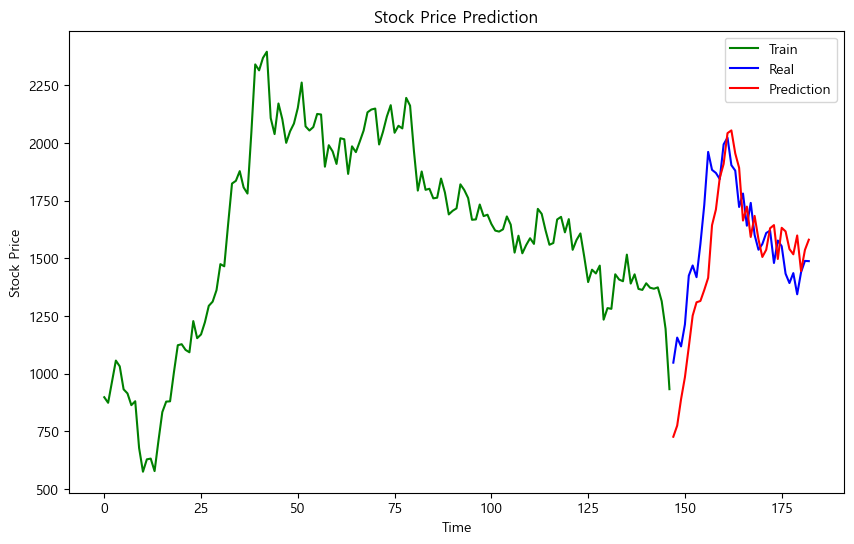

In [ ]:
# 예측
val_predict = model.predict(x_test)

# 역 변환기
scaler_y = StandardScaler()
scaled_data_y = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1,1))

# 예측 값 스케일 역변환
val_predict = scaler_y.inverse_transform(val_predict)

# 실제 값 스케일 역변환
y_train = scaler_y.inverse_transform(y_train.reshape(-1,1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(10,6))
# Add the training set to the plot:
plt.plot(y_train, color='green', label='Train')
# Plot the test and prediction data:
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(y_train), len(y_train)+len(y_test)), val_predict, color='red', label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()




In [ ]:
# val_predict

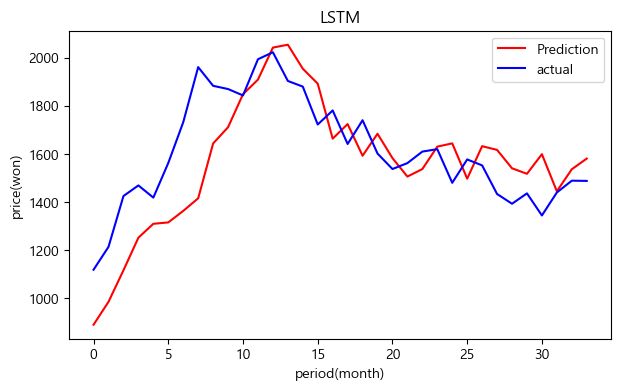

In [ ]:
# 예측

plt.figure(figsize=(7,4))
plt.title('LSTM')
plt.ylabel('price(won)')
plt.xlabel('period(month)')
plt.plot(val_predict[2:], label = 'Prediction', color='r')
plt.plot(y_test[2:], label = 'actual', color='b')
plt.legend(loc='best')
plt.show()

## 5. 평가지표

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Calculate mean absolute error
mae = mean_absolute_error(val_predict[2:],y_test[2:])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(val_predict[2:], y_test[2:])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

#Calculate mean_absolute_percentage_error
mape = mean_absolute_percentage_error(val_predict[2:],y_test[2:])
print('MAPE: %f' % mape)

MAE: 144.375520
MSE: 33498.267296
RMSE: 183.025319
MAPE: 0.101809


In [ ]:
pred = pd.Series(val_predict.flatten()).pct_change()
test = pd.Series(y_test.flatten()).pct_change()

In [ ]:
re = 1
for i in range(len(pred)):
  if pred[i] > 0:
    re *= (1+test[i])

re

1.3903891329067144

In [ ]:
df = pd.DataFrame({
    '예측': val_predict.flatten(),
    '종가': y_test.flatten()
})
# df


In [ ]:
df['trade'] = ''

df['trade'] = np.where(df['예측'].shift(-1) > df['예측'], 'buy', '')
df['buy_price'] = df.loc[df['trade'] == 'buy', '종가']
df['next_day_price'] = df['종가'].shift(-1)  # 다음 날의 종가를 새로운 컬럼으로 추가
df['profit'] = np.where(df['trade'] == 'buy', df['next_day_price'] - df['buy_price'], np.nan)  # 수익 계산
df['return'] = df['profit'] / df['buy_price']  # 수익률 계산
df['profit'] = df['profit'].fillna(0)
df['return'] = df['return'].fillna(0)
# df

In [ ]:
ret = 1
cum_ret = []
for value in df['return']:
    if not pd.isnull(value):
        ret *= (1 + value)
    cum_ret.append(ret)
df['누적 수익률'] = cum_ret
df


,예측,종가,trade,buy_price,next_day_price,profit,return,누적 수익률
0,726.670837,1047.710000,buy,1047.710000,1156.360000,108.650000,0.103702,1.103702
1,774.825562,1156.360000,buy,1156.360000,1118.170000,-38.190000,-0.033026,1.067251
2,889.405396,1118.170000,buy,1118.170000,1213.420000,95.250000,0.085184,1.158164
3,984.759277,1213.420000,buy,1213.420000,1424.680000,211.260000,0.174103,1.359804
4,1115.851929,1424.680000,buy,1424.680000,1468.870000,44.190000,0.031017,1.401981
5,1251.453979,1468.870000,buy,1468.870000,1418.120000,-50.750000,-0.034550,1.353542
6,1309.256592,1418.120000,buy,1418.120000,1562.350000,144.230000,0.101705,1.491205
7,1314.999023,1562.350000,buy,1562.350000,1731.680000,169.330000,0.108382,1.652824
8,1362.850342,1731.680000,buy,1731.680000,1960.990000,229.310000,0.132421,1.871692
9,1415.322510,1960.990000,buy,1960.990000,1883.220000,-77.770000,-0.039659,1.797463
